# Prova 3

Instructions:
- Exercises are grouped by topic and ordered by increasing difficulty within each topic.
- Submit your solutions in a well-organized Jupyter notebook.
- You are responsible for creating robust test cases for each question. Ensure your tests cover all possible cases, especially edge cases (e.g., with the largest possible N ).
- Verify that all your solutions meet the specified time constraints. Unless otherwise stated, each question has a 1-second time limit. Some of the later questions may have different limits, which will be indicated.
- Be sure that the inputs (which will be created by you) match the specifications, and your solutions meets the required time limit.
- Presentation matters: make sure your notebook is clean, well-structured, and that both solutions and test cases are clearly labeled.

In [170]:
# from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import (
    HGate, 
    ZGate, 
    XGate, 
    YGate,
    IGate,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import (
    plot_bloch_multivector,
    array_to_latex, 
    plot_histogram,
)
from sympy.parsing.sympy_parser import parse_expr
from sympy.logic.inference import satisfiable


import numpy as np
from numpy.random import default_rng, shuffle

rng = default_rng()

## Distinguishing Unitaries and States

**Exercise 1.** You are given an operation that implements a single-qubit unitary transformation: either the H gate or the X gate. The operation will have Adjoint and Controlled variants defined. Your task is to perform necessary operations and measurements to figure out which unitary it was and to return 0 if it was the H gate or 1 if it was the X gate. You are allowed to apply the given operation and its adjoint/controlled variants at most twice. You have to implement an operation which takes a single-qubit operation as an input and returns an integer.

In [243]:
# 0 -> Gate H, 1 -> Gate X 
def solve1(operator) -> int:
    # We'll apply UXU|0> and measure.
    # When U=X -> XXX|0> = X|0> = |1>
    # When U=H -> HXH|0> = HX(|0>+|1>) = H(|0>+|1>) = |0>
    
    qc = QuantumCircuit(1, 1)           # 1 quibit + 1 bit (output measure)
    qc.append(operator, [0])
    qc.x(0)
    qc.append(operator, [0])
    
    qc.measure(0, 0)
    # qc.draw('mpl') # plot the circuit
    
    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val

    return int([k for k in result.keys()][0])
    

In [244]:
# Testing 

tests = [i%2 for i in range(20)]
shuffle(tests)
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'X':0, 'H':0}
for tt in tests:
    gate = XGate() if tt == 1 else HGate()
    tests_inputs[('X' if tt == 1 else 'H')] += 1
    expected = tt
    res = solve1(gate)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'X': 10, 'H': 10}
{'Accepted': 20, 'Wrong Answer': 0}


**Exercise 2.** You are given an operation that implements a single-qubit unitary transformation: either the identity (I gate) or one of the Pauli gates (X, Y or Z gate). The operation will have Adjoint and Controlled variants defined. Your task is to perform necessary operations and measurements to figure out which unitary it was and to return

- 0 if it was the I gate,
- 1 if it was the X gate,
- 2 if it was the Y gate,
- 3 if it was the Z gate.

You are allowed to apply the given operation and its adjoint/controlled variants exactly once. You have to implement an operation which takes a single-qubit operation as an input and returns an integer.

In [278]:
# 0 -> Gate I, 1 -> Gate X, 2 -> Gate Y, 3 -> Gate Z 
def solve2(U_gate) -> int:
    # In: 1-qubit Operator 
    # We'll use the Bell States, from the |\Phi_+> we'll apply the Gate U
    # And we know where the States will be, in some Bell state so get them back by a measurement
    
    # Preparing |\Phi_+>
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(control_qubit=0, target_qubit=1)

    # Appy the U x I
    qc.append(U_gate, [0])

    # Measure in the Bell states -> Back into {|00>, |01>, |10>, |11>}
    # 00 -> I, 10 -> X, 01 -> Z, 11 -> Y
    qc.cx(control_qubit=0, target_qubit=1)
    qc.h(0)

    qc.measure([0,1],[0,1])

    # qc.draw('mpl') # Plot the circuit

    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val
    
    result = [el for el in result.keys()][0]
    mp = {'00': 0, '10' : 1, '01' : 3, '11' : 2}
    return mp[result]

res = solve2(ZGate())
res

3

In [281]:
# Testing 
tests = [i%4 for i in range(200)]
shuffle(tests)
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'I':0, 'X':0, 'Y':0, 'Z':0}
inmap = {0: 'I', 1:'X', 2:'Y', 3:'Z'}
gatemap = {0: IGate(), 1:XGate(), 2:YGate(), 3:ZGate()}

for tt in tests:
    gate = gatemap[tt]
    tests_inputs[inmap[tt]] += 1
    expected = tt
    
    res = solve2(gate)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'I': 50, 'X': 50, 'Y': 50, 'Z': 50}
{'Accepted': 200, 'Wrong Answer': 0}


**Exercise 3.** You are given 3 qubits which are guaranteed to be in one of the two states:
|ψ0⟩ = 1
√3(|100⟩ + ω|010⟩ + ω2|001⟩)
|ψ1⟩ = 1
√3(|100⟩ + ω2|010⟩ + ω|001⟩)
where ω = e2iπ/3.
Your task is to perform necessary operations and measurements to figure out which state
it was and to return 0 if it was |psi0⟩ state or 1 if it was |ψ1⟩ state. The state of the qubits
after the operations does not matter.
You have to implement an operation which takes an array of 3 qubits as an input and
returns an integer.

**Exercise 4.** You are given two qubits in state |00⟩. Your task is to create the following
state on them: (|00⟩ + |01⟩ + |10⟩)/√3.
You have to implement an operation which takes an array of 2 qubits as an input and
has no output. The ”output” of your solution is the state in which it left the input qubits.

Statevector([0.57735027+0.j, 0.57735027+0.j, 0.57735027+0.j,
             0.        +0.j],
            dims=(2, 2))


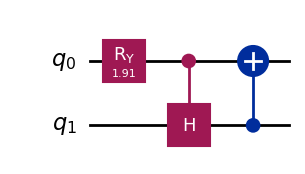

In [283]:
from math import acos, sqrt

def solve4():
    # As done in Assignment 3, question 3.
    # R_y(k) = cos(k/2)|0> + sin(k/2)|1> 
    # with k = 2 arccos(1/\sqrt(3)), R_y |0> = \sqrt(1/3)|0> + \sqrt(2/3)|1> 
    # 1- So, R_y(k)|00> =  \sqrt(1/3)|00> + \sqrt(2/3)|10>
    # 2- Apply ctr-H (0 -> 1) => \sqrt(1/3)|00> + \sqrt(2/3)[\sqrt(1/2)(|10>+|11>)] = \sqrt(1/3)[|00> + |10> + |11>]
    # 3- Finally apply ctr-X (1 -> 0) => \sqrt(1/3)[|00> + |10> + |01>]
    
    angle = 2 * acos(1/sqrt(3))
    
    qc = QuantumCircuit(2,0)
    
    # 1.
    qc.ry(angle, [0])
    
    # 2. 
    qc.ch(control_qubit=0,target_qubit=1)
    
    # 3. 
    qc.cx(control_qubit=1, target_qubit=0)
    
    
    state = Statevector(qc)
    return qc, state
    
qc, _ = solve4()
qc.draw('mpl')
    

In [290]:
# Testing
_, state = solve4()
expected = Statevector([1/sqrt(3),1/sqrt(3),1/sqrt(3), 0])

result_test = {'Accepted':0, 'Wrong Answer':0}
result_test['Accepted' if state.equiv(expected) else 'Wrong Answer'] += 1
print(result_test)

{'Accepted': 1, 'Wrong Answer': 0}


**Exercise 5.** You are given N qubits in the state |0 · · · 0⟩, and an integer parity ∈ {0, 1}.
Your task is to prepare an equal superposition of all basis states that have the given parity
of the number of 1s in their binary notation, i.e., the basis states that have an even number
of 1s if parity=0 or the basis states that have an odd number of 1s if parity=1.
For example, for N = 2 the required state would be (|00⟩ + |11⟩)/√2 if parity=0, and
(|01⟩ + |10⟩)/√2 if parity=1.
You are not allowed to use any gates except the Pauli gates (X, Y and Z), the Hadamard
gate and the controlled versions of those (you are allowed to use multiple qubits as controls
in the controlled versions of gates). However, you are allowed to use measurements.
You have to implement an operation which takes an array of N qubits and an integer as
an input and has no output. The ”output” of your solution is the state in which it left the
input qubits.

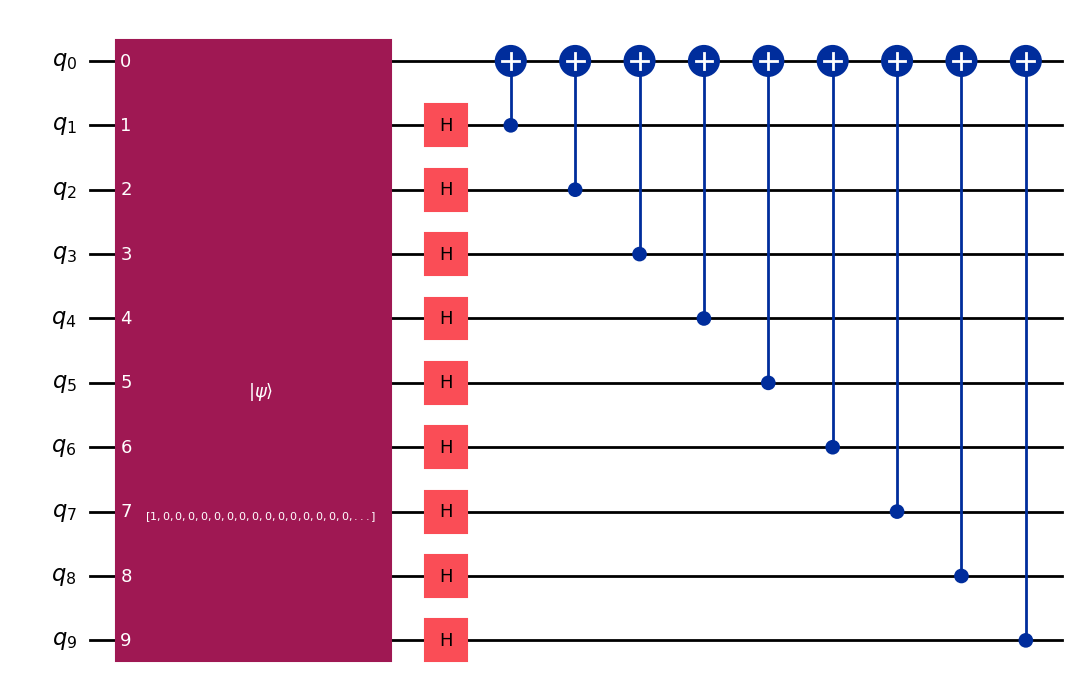

In [304]:
def solve5(initial_state : Statevector, N: int, parity : int) -> None:

    qc = QuantumCircuit(N)
    qc.initialize(initial_state)
    for i in range(1, N):
        qc.h(i)
        
    for i in range(1, N):
        qc.cx(control_qubit=i, target_qubit=0)
        
    # In the final we have the string with even number of ones, because 
    # - we invert the 0-qubit even times if the [1, n-1] have even one bits, the 0-qubit goes to 0 so the bit string have even ones.
    # - we invert the 0-qubit odd times if the [1, n-1] have odd one bits, the 0-qubit goes to 1 so the bit string have even ones.
    
    if parity == 1:
        qc.x(0)
    
    state = Statevector(qc)
    return qc, state


qc, _ = solve5(Statevector.from_label('0'*10), 10, 0)
qc.draw('mpl')

In [339]:
# Testing
N = 10
strs = [[] for _ in range(2)]
for i in range(2**N):
    cnt = bin(i).count('1')
    strs[cnt%2].append(i)
    
for i in range(2): # parity
    print('parity', i)
    _, state = solve5(Statevector.from_label('0'*N), N, i)
    state = state.data 
    strs_expected = strs[i]
    expected_c = 1/sqrt(len(strs_expected))
    
    print('\tTesting the number of amplitutes equal to expected')
    diff_zero_states = [el for el in state if el != 0]
    if len(strs_expected) == len(diff_zero_states):
        print('\t\tAccepted')
    else :
        print('\t\tWrong Answer')
    # print('Expected:', len(strs_expected), 'Got: ', len(diff_zero_states))

    print('\tTesting the setted indices are the expected')
    cnt = 0
    for i in strs_expected:
        if np.isclose(state[i], expected_c):
            cnt += 1 
        else: print(state[i], expected_c)
    
    if cnt == len(strs_expected):
        print('\t\tAccepted')
    else:
        print('\t\tWrong Answer')

parity 0
	Testing the number of amplitutes equal to expected
		Accepted
	Testing the setted indices are the expected
		Accepted
parity 1
	Testing the number of amplitutes equal to expected
		Accepted
	Testing the setted indices are the expected
		Accepted


**Exercise 6.** You are given two qubits which are guaranteed to be in one of the Bell states:
|Φ+⟩ = 1
√2 (|00⟩ + |11⟩)
|Φ−⟩ = 1
√2 (|00⟩ − |11⟩)
|Ψ+⟩ = 1
√2 (|01⟩ + |10⟩)
|Ψ−⟩ = 1
√2 (|01⟩ − |10⟩)
2
Your task is to perform necessary operations and measurements to figure out which state it
was and to return the index of that state (0 for Φ+, 3 for Ψ−, etc.). The state of the qubits
after the operations does not matter.
You have to implement an operation which takes an array of two qubits as an input and
returns an integer.

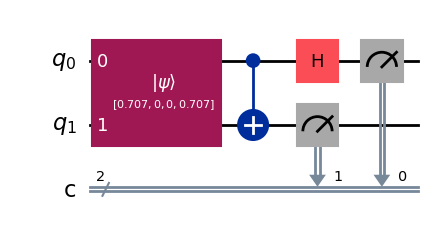

In [383]:
def solve6(initial_state : Statevector) -> int:
    # It's like what's done in exercise 2
    qc = QuantumCircuit(2, 2)
    qc.initialize(initial_state)
    
    # Moving to {|00>, |01>, |10>, |11>} basis in measurement
    qc.cx(0, 1)
    qc.h(0)
    
    qc.measure([0,1],[0,1])

    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val
    result = [el for el in result.keys()][0]
    mp = {'00': 0, '01' : 1, '10' : 2,  '11' : 3}
    return qc, mp[result]


def get_bell_state(name: str):
    # Preparing |\Phi_+> 
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(control_qubit=0, target_qubit=1)
    
    if name == 'Phi-': 
        qc.z(0)
    elif name == 'Psi+':
        qc.x(0)
    elif name == 'Psi-':
        qc.y(0)
    
    return Statevector(qc)
    
    
qc, _ = solve6(get_bell_state('Phi+'))
qc.draw('mpl')

In [388]:
# Testing
 
tests = [i%4 for i in range(200)]
shuffle(tests) # Shuffles the test array
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'Phi+':0, 'Phi-':0, 'Psi+':0, 'Psi-':0}
inmap = {0: 'Phi+', 1:'Phi-', 2:'Psi+', 3:'Psi-'}
states = { i: get_bell_state(inmap[i]) for i in range(4) }

for tt in tests:
    state_to_test = states[tt]
    tests_inputs[inmap[tt]] += 1
    expected = tt
    
    _, res = solve6(state_to_test)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
        print('Expected', expected, 'Got', res)
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'Phi+': 50, 'Phi-': 50, 'Psi+': 50, 'Psi-': 50}
{'Accepted': 200, 'Wrong Answer': 0}
